In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from pathlib import Path

import src.data.process_matlab as pmat
import src.data.aggregate as aggr

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_rows = 10
pd.options.display.max_columns = 100

# Check Aggregates
First, check that the cup data looks like a promising alternative to the sonics. Does it:
* have enough availability (counts)
* have a reasonable looking distribution of variance (no long failures or severe data issues)

In [7]:
# load aggregated data
agg_path = Path('../data/processed/cup.parquet')
assert agg_path.exists()

In [8]:
agg = pd.read_parquet(agg_path)

In [15]:
agg = agg.loc[:,['height', 'nan_count', 'mean', 'mean_square', 'cum_square_sd_30s', 'min', 'max', 'timestamp', '3s_gust']]

In [16]:
agg['var'] = agg['mean_square'] - agg['mean'].pow(2)

The loglog histogram below shows a fair amount of bad data with zero variance (shifted to 1e-6) and crazy outliers up around 1e+6.

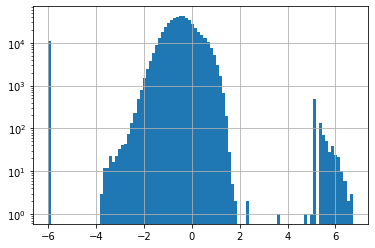

In [28]:
agg['var'].add(1e-6).transform(np.log10).hist(bins=100, log=True)

In [30]:
pd.cut(agg['var'], [-np.inf, 1e-6, 1e2, np.inf]).value_counts()

(1e-06, 100.0]    498889
(-inf, 1e-06]      11142
(100.0, inf]         869
Name: var, dtype: int64

In [32]:
agg['log_var'] = agg['var'].replace(0, np.nan).transform(np.log10)

Plotting histograms by sensor shows that the vast majority of extreme outliers are on a single sensor, at height=3. Next I'll check if there are *any* of those values on other sensors.

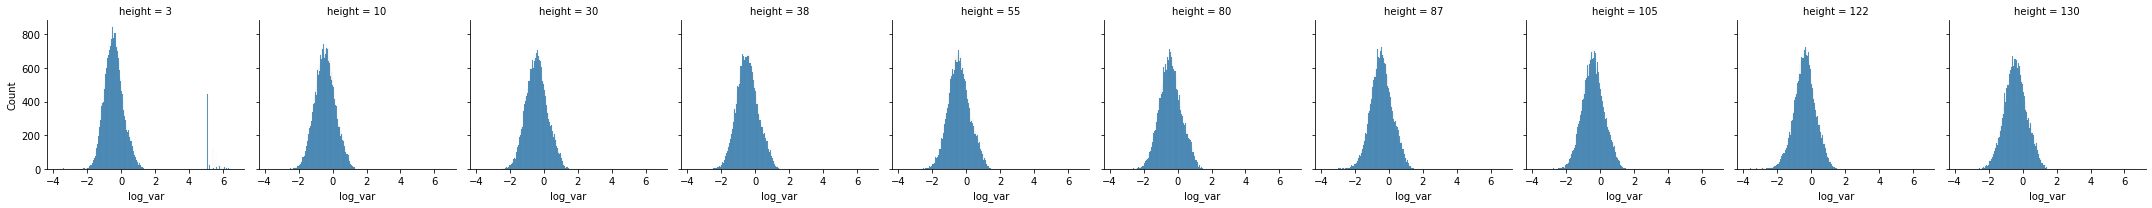

In [40]:
sns.displot(data=agg, x='log_var', col='height', height=3, aspect=1)

The following table confirms that sensors at heights other than 3 are not significant contributors of extreme outliers.

In [44]:
agg.groupby('height')['log_var'].agg(lambda x: (x > 3).sum())

height
3      862.0
10       2.0
30       0.0
38       0.0
55       0.0
80       1.0
87       1.0
105      0.0
122      1.0
130      0.0
Name: log_var, dtype: float64

# Move Ahead with ETL
Due to the 180GB data size, the sonic ETL process had to be an all-in-one operation that combined data extraction with some analysis and feature creation. I won't need to do that here. The cup data has 1/20th the sample frequency, and I'll only take a subset of the top few instruments, so the extracted data will only be a few GB and fit in memory. Then I can leave analysis as a separate task.

In [45]:
test_path = Path('../data/raw/10_01_2019_00_00_00_000.mat')
assert test_path.exists()

I extended the functionality of pmat.matlab_to_pandas() and wrote a script (extract_cups_1hz.py) to process all the data. Below is just checking along the way.

In [74]:
cups = pmat.matlab_to_pandas(test_path, timestamps=True, col_subset=pmat.CUP_SUBSET)

In [75]:
cups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Air_Temp_87m     600 non-null    float32       
 1   DeltaT_122_87m   600 non-null    float32       
 2   Dewpt_Temp_122m  600 non-null    float32       
 3   Dewpt_Temp_87m   600 non-null    float32       
 4   PRECIP_INTEN     600 non-null    float32       
 5   Cup_WS_C1_130m   600 non-null    float32       
 6   Cup_WS_122m      600 non-null    float32       
 7   Cup_WS_C1_105m   600 non-null    float32       
 8   Vane_WD_122m     600 non-null    float32       
 9   Vane_WD_87m      600 non-null    float32       
 10  timestamp        600 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(10)
memory usage: 28.2 KB


In [76]:
cups.head()

,Air_Temp_87m,DeltaT_122_87m,Dewpt_Temp_122m,Dewpt_Temp_87m,PRECIP_INTEN,Cup_WS_C1_130m,Cup_WS_122m,Cup_WS_C1_105m,Vane_WD_122m,Vane_WD_87m,timestamp
0,16.483389,-0.361444,8.047009,8.165394,2.966418,5.816689,5.801024,5.810657,331.159210,318.666260,2019-09-30 17:00:00
1,16.395626,-0.365807,8.040517,8.152415,2.964146,5.237696,6.023145,6.380082,332.660950,324.725952,2019-09-30 17:00:01
2,16.457386,-0.357081,8.059991,8.132948,2.959603,5.203672,6.098693,5.677698,338.991425,324.404602,2019-09-30 17:00:02
3,16.454134,-0.358535,8.059991,8.106991,2.961550,5.119934,5.986108,5.959190,337.281738,325.391602,2019-09-30 17:00:03
4,16.525644,-0.357081,8.085957,8.139437,2.959603,4.955215,5.634127,5.964228,324.921173,321.948578,2019-09-30 17:00:04
